# theta_bouts.ipynb

In [1]:
# General
import sys
import os
import os.path as op
import glob
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Neuro
import mne
from ptsa.data.TimeSeriesX import TimeSeries 
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series
from neurodsp.sim import sim_combined
from bycycle.features import compute_features
from bycycle.cyclepoints import find_extrema, find_zerox
from bycycle.cyclepoints.zerox import find_flank_zerox
from bycycle.plts import plot_burst_detect_summary, plot_cyclepoints_array, plot_feature_hist
from bycycle.group import compute_features_2d
from bycycle.utils.download import load_bycycle_data

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)
rdbu_cut = sns.color_palette('RdBu_r', 500)[50:450]

labelfontsize = 12
tickfontsize = 12
figfontsize = 14
labfs = labelfontsize
tickfs = tickfontsize
figfs = figfontsize
font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

proj_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta'

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ptsa/data/TimeSeriesX.py:7: DeprecationWarning: importing from ptsa.data.TimeSeries is deprecated; import from ptsa.data.timeseries instead
  DeprecationWarning)


In [4]:
freqs = np.array([2**((i/2) - 1) for i in range(16)])

In [5]:
def get_hpc_chans(proj_dir='/home1/dscho/projects/unit_activity_and_hpc_theta'):
    """Return a dataframe of hippocampal probes and their microwire channels for every session."""
    u2r_files = glob(op.join(proj_dir, 'data', 'crosselec_phase_locking', 'metadata', '*region_pairs_df.pkl'))
    u2r_df = pd.concat([dio.open_pickle(_f) for _f in u2r_files], axis=0).reset_index(drop=True)
    
    edges = ['ctx-hpc', 'hpc-hpc', 'hpc-local']
    hpc_rois = ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH']
    qry = "(edge=={}) & (lfp_hemroi=={})".format(edges, hpc_rois)
    drop_idx = u2r_df.query("(subj_sess==['U394_ses3', 'U387_ses1', 'U387_ses2', 'U387_ses3']) & (lfp_hemroi=='RAH')").index
    cols = ['subj_sess', 'lfp_hemroi', 'lfp_chan_inds']
    hpc_chans = (u2r_df.drop(index=drop_idx)
                       .query(qry)
                       .drop_duplicates(['subj_sess', 'lfp_hemroi'])
                       .sort_values(['subj_sess', 'lfp_hemroi'])
                       .reset_index(drop=True)[cols])
    return hpc_chans

In [6]:
def get_power(subj_sess,
              chans,
              l_freq=None,
              h_freq=None,
              sr=2000,
              notch_freqs=[60, 120],
              zscore_power=False,
              return_lfps=False):
    """Return a channel x timepoint array of power values.
    
    Loads LFP for the selected channels,
    applies a notch filter if specified,
    applies an FIR filter if specified,
    and returns power from the Hilbert transform.
    
    Parameters
    ----------
    subj_sess : str
        e.g. 'U367_env2'
    chans : list[str]
        Corresponds to the numbering of raw EEG, CSC#.mat files.
    l_freq : int
        See FIR filter options below.
    h_freq : int
        See FIR filter options below.
    sr : int
        Sampling rate in Hz.
    notch_freqs : list[int]
        List of frequencies to notch filter.
    zscore_power : bool
        If True, power values are Z-scored over time, within channel.
        
    FIR filter options
    ------------------
    high-pass : l_freq is not None, h_freq is None
    low-pass  : l_freq is None, h_freq is not None
    band-pass : l_freq < h_freq
    band-stop : l_freq > h_freq
    
    Returns
    -------
    if return_lfps:
        lfp : ndarray
            channel x timepoint array of notch-filtered LFPs.
        lfp_filt : ndarray
            channel x timepoint array of FIR-filtered LFPs.
        power : ndarray
            channel x timepoint array of powers.
    else:
        power : ndarray
            channel x timepoint array of powers.
    """
    # Load and preprocess LFPs for the selected channels.
    subj_df = phase_locking.get_subj_df()
    _, lfp = manning_analysis.process_lfp(subj_sess, 
                                          subj_df=subj_df,
                                          chans=chans,
                                          sampling_rate=sr,
                                          notch_freqs=notch_freqs)
    
    # Filter the LFP signal.
    lfp_filt = lfp.copy()
    if l_freq or h_freq:
        lfp_filt = spp.filter_lfp(lfp, 
                                  l_freq=l_freq,
                                  h_freq=h_freq)
    
    # Estimate power from the Hilbert transform.
    power, _ = spp.get_hilbert(lfp_filt,
                               zscore_power=zscore_power)
    
    if return_lfps:
        return lfp, lfp_filt, power
    else:
        return power

In [7]:
def mask_power(power,
               zthresh=5,
               win=2.5,
               sr=2000):
    """Return a mask of power values > zthresh, and an window around them.
    
    Powers are Z-scored over time, within each channel.
    
    If win = 0, just returns a mask of values > zthresh.
    
    Parameters
    ----------
    power : ndarray
        Vector of timepoints or chan x timepoint matrix.
    zthresh : int or float
        Z-score threshold.
    win : int or float
        How many ms to mask before and after each suprathreshold value.
    sr : int
        Sampling rate in Hz.
    
    Returns
    -------
    power_mask : ndarray
    """
    # Format data.
    shp = power.shape
    if len(power.shape) == 1:
        power = np.expand_dims(power, 0)
    
    # Z-score powers.
    power = stats.zscore(power, axis=-1)
    
    # Binarize values above and below threshold.
    power_mask = np.zeros(power.shape, dtype=int)
    power_mask[power>zthresh] = 1
    xinds, yinds= np.where(power_mask)
    
    # Expand the mask around each suprathreshold value.
    n_timepoints = power.shape[1]
    steps = int(win * (sr/1000))
    if steps > 0:
        xinds_new = []
        yinds_new = []
        for iChan in np.unique(xinds):
            _yinds = []
            for step in range(-steps, steps+1):
                _yinds += list(yinds[xinds==iChan] + step)
            _yinds = np.unique(_yinds)
            _yinds = _yinds[(_yinds>=0) & (_yinds<n_timepoints)]
            xinds_new += list(np.repeat(iChan, len(_yinds)))
            yinds_new += list(_yinds)

        # Apply the mask values.
        power_mask[xinds_new, yinds_new] = 1
    
    # Return power_mask in the shape that power was inputted.
    power_mask = power_mask.reshape(shp)
    
    return power_mask

In [8]:
hpc_chans = get_hpc_chans()
print('hpc_chans: {}'.format(hpc_chans.shape))

hpc_chans: (86, 3)


In [348]:
# Save suprathreshold HFA indices for each hippocampal channel.
hfa_dir = op.join(proj_dir, 'data', 'crosselec_phase_locking', 'hfa_inds')
l_freq = 200
zthresh = 3
win = 2.5
sr = 2000
notch_freqs = [60, 120]
overwrite = True

start_time = time()

hfa_prop = []
hfa_rate = []
for idx, row in hpc_chans.iterrows():
    subj_sess = row['subj_sess']
    chans = [str(iChan+1) for iChan in row['lfp_chan_inds']]

    # Get HFA power and mask (same shape arrays, channel x timepoint).
    power_hfa = get_power(subj_sess, 
                          chans=chans, 
                          l_freq=l_freq, 
                          sr=sr,
                          notch_freqs=notch_freqs,
                          return_lfps=False)

    hfa_mask = mask_power(power_hfa,
                          zthresh=zthresh, 
                          win=win,
                          sr=sr)
    
    hfa_prop.append(np.mean(hfa_mask, axis=1).tolist())
    hfa_rate.append(list(sr * np.mean(hfa_mask, axis=1)))
    
    # Save output files.
    for iChan, chan in enumerate(chans):
        hfa_filename = op.join(hfa_dir, 
                               'hfa_inds-{}Hz-zthresh{}-win{}ms-{}-iChan{}.pkl'
                               .format(sr, zthresh, win, subj_sess, int(chan) - 1))
        if overwrite or not op.exists(hfa_filename):
            hfa_inds = np.where(hfa_mask[iChan, :])[0]
            dio.save_pickle(hfa_inds, hfa_filename, verbose=False)
        
hpc_chans['hfa_prop'] = hfa_prop
hpc_chans['hfa_rate'] = hfa_rate

print('Done in {:.1f}s'.format(time() - start_time))

Done in 1021.2s


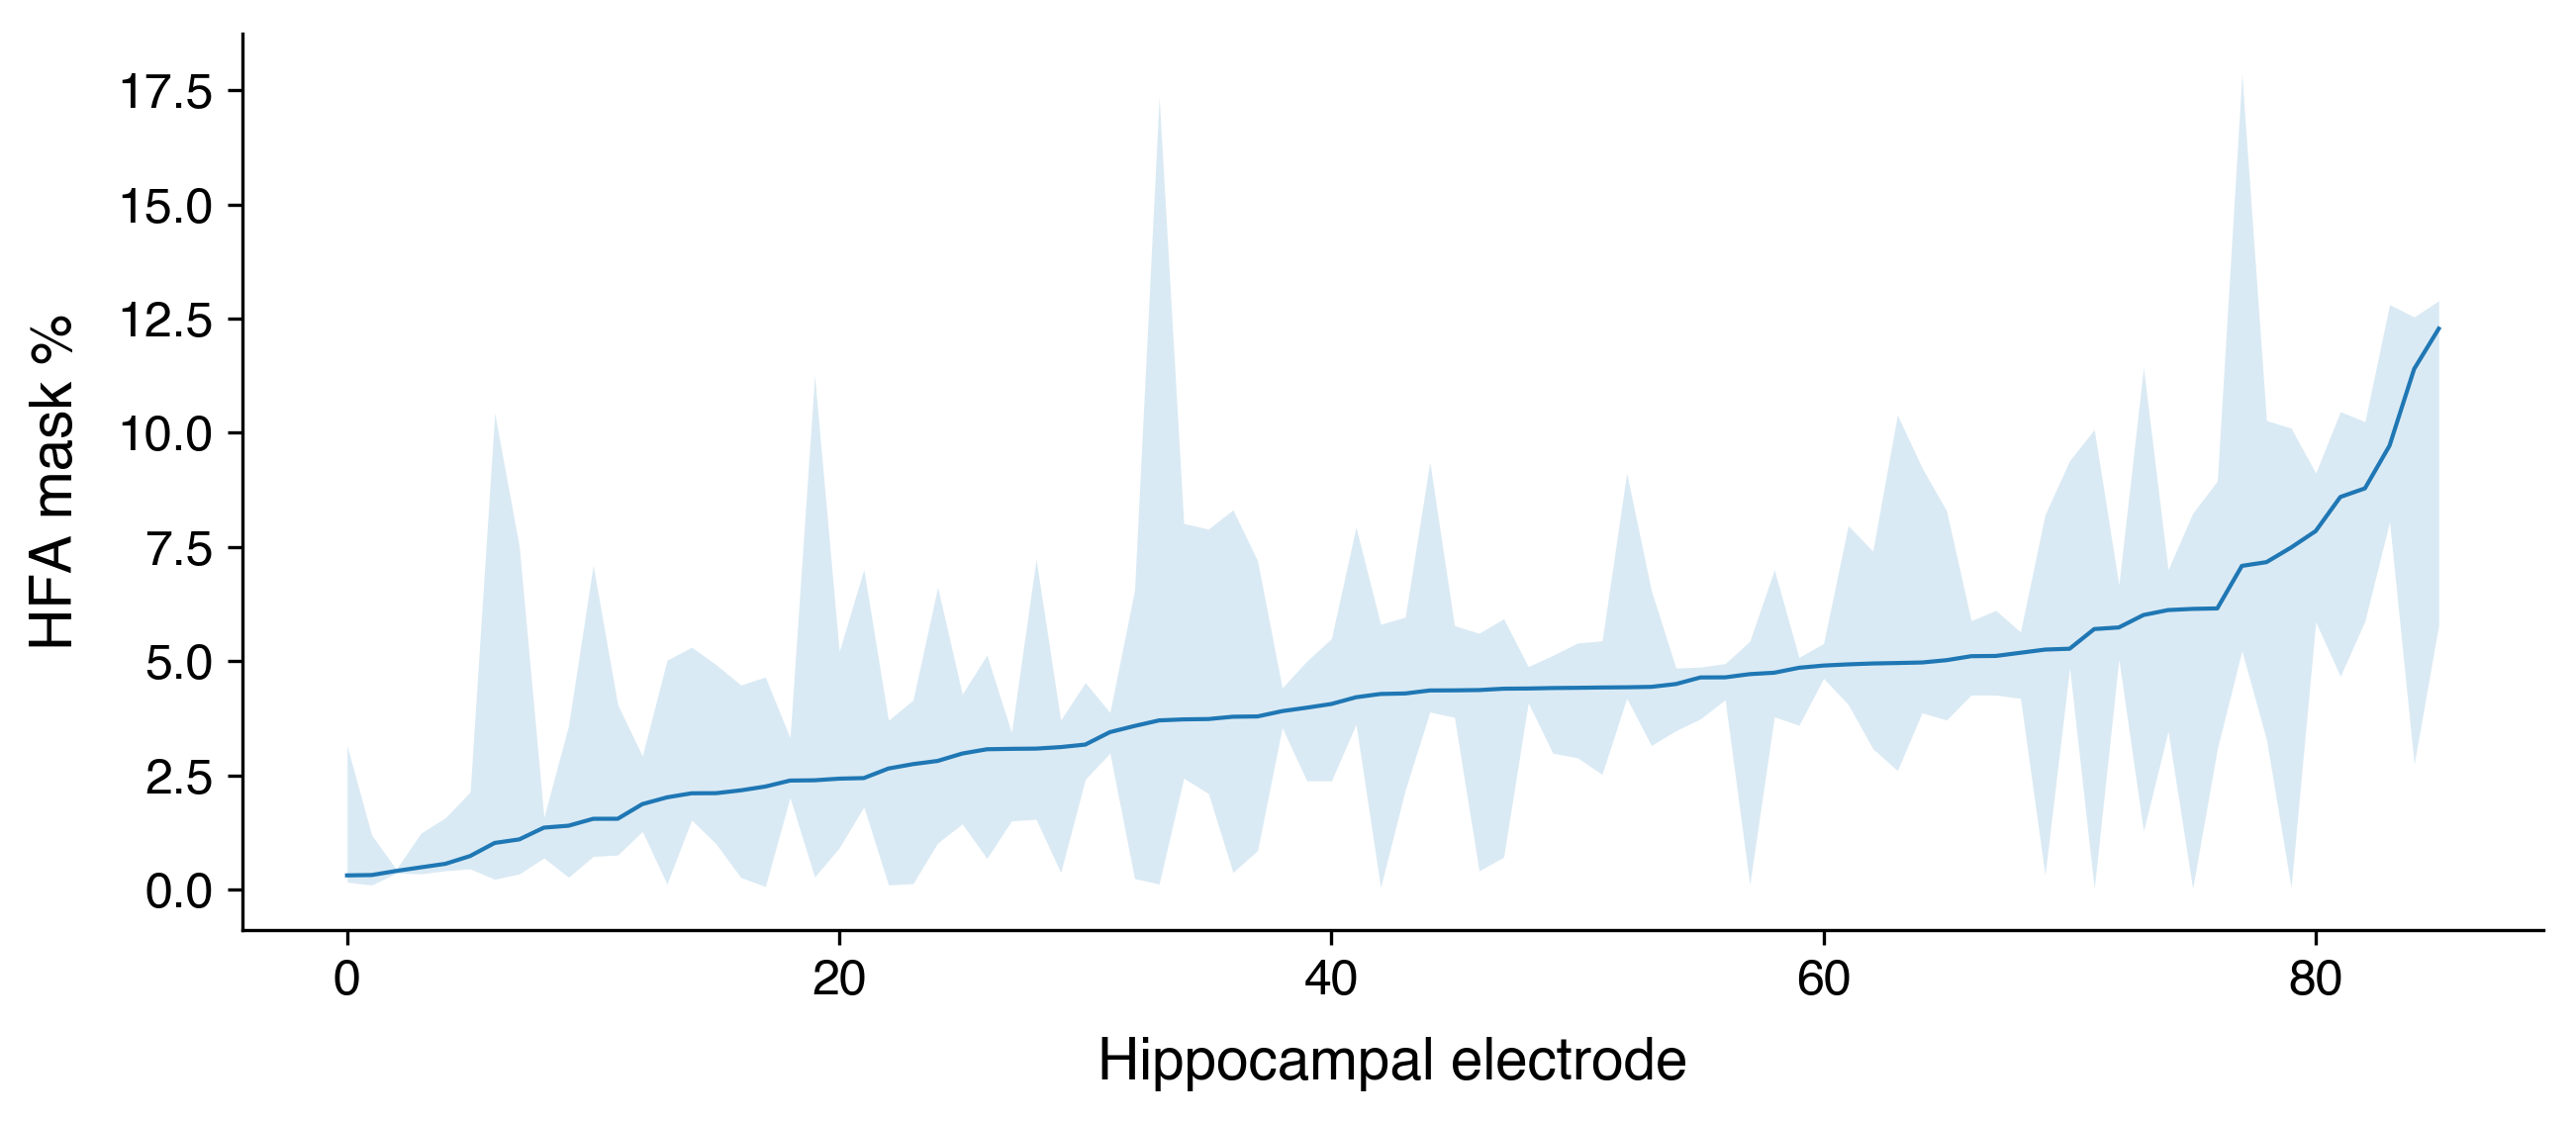

In [369]:
hfa_prop = np.array(hpc_chans['hfa_prop'].apply(lambda x: [len(x), np.min(x), np.median(x), np.max(x)]).tolist())
hfa_prop = hfa_prop[np.argsort(hfa_prop[:, 2]), :]

plt.close()
plt.fill_between(np.arange(hfa_prop.shape[0]), 100 * hfa_prop[:, 1], 100 * hfa_prop[:, 3], color=colors[0], alpha=0.2, lw=0)
plt.plot(100 * hfa_prop[:, 2])
plt.xlabel('Hippocampal electrode')
plt.ylabel('HFA mask %')
plt.show()

In [371]:
pl_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region/hfa_removed'
input_files = glob(op.join(pl_dir, 'phase_locking_stats*-remove_hfa_z3_2.5ms-*.pkl'))
pl_df = pd.DataFrame(dio.open_pickle(input_files[0])).T
for f in input_files[1:]:
    pl_df = pl_df.append(dio.open_pickle(f))
pl_df.reset_index(drop=True, inplace=True)

pl_df.shape

(317, 46)

In [372]:
pl_df.groupby('edge').agg('sig_z_fdr')

edge
hpc-local    317
dtype: int64

In [16]:
hpc_chans.query("(subj_sess=='{}') & (lfp_hemroi=='LPH')".format(subj_sess))['lfp_chan_inds'].iloc[0]

[40, 41, 42, 43, 44, 45, 46, 47]

In [26]:
subj_sess = 'U371_env1'
hemroi = 'LPH'
sr = 2000
notch_freqs = [60, 120]

if not 'subj_df' in dir():
    subj_df = phase_locking.get_subj_df()
chans = [str(x+1) for x in hpc_chans.query("(subj_sess=='{}') & (lfp_hemroi=='{}')".format(subj_sess, hemroi))['lfp_chan_inds'].iloc[0]]
_, lfp = manning_analysis.process_lfp(subj_sess, 
                                      subj_df=subj_df, 
                                      chans=chans,
                                      sampling_rate=sr,
                                      notch_freqs=notch_freqs)

In [41]:
np.array([2**((i/2) - 1.5) for i in range(18)])

array([  0.35355339,   0.5       ,   0.70710678,   1.        ,
         1.41421356,   2.        ,   2.82842712,   4.        ,
         5.65685425,   8.        ,  11.3137085 ,  16.        ,
        22.627417  ,  32.        ,  45.254834  ,  64.        ,
        90.50966799, 128.        ])

In [49]:
freqs[3:6]

array([1.41421356, 2.        , 2.82842712])

In [42]:
h_freq = 200
dur = 30
_lfp = lfp.values[0, :sr*dur]

# Lowpass filter.
lfp_filt = filter_signal(_lfp, sr, 'lowpass', h_freq, remove_edges=False)

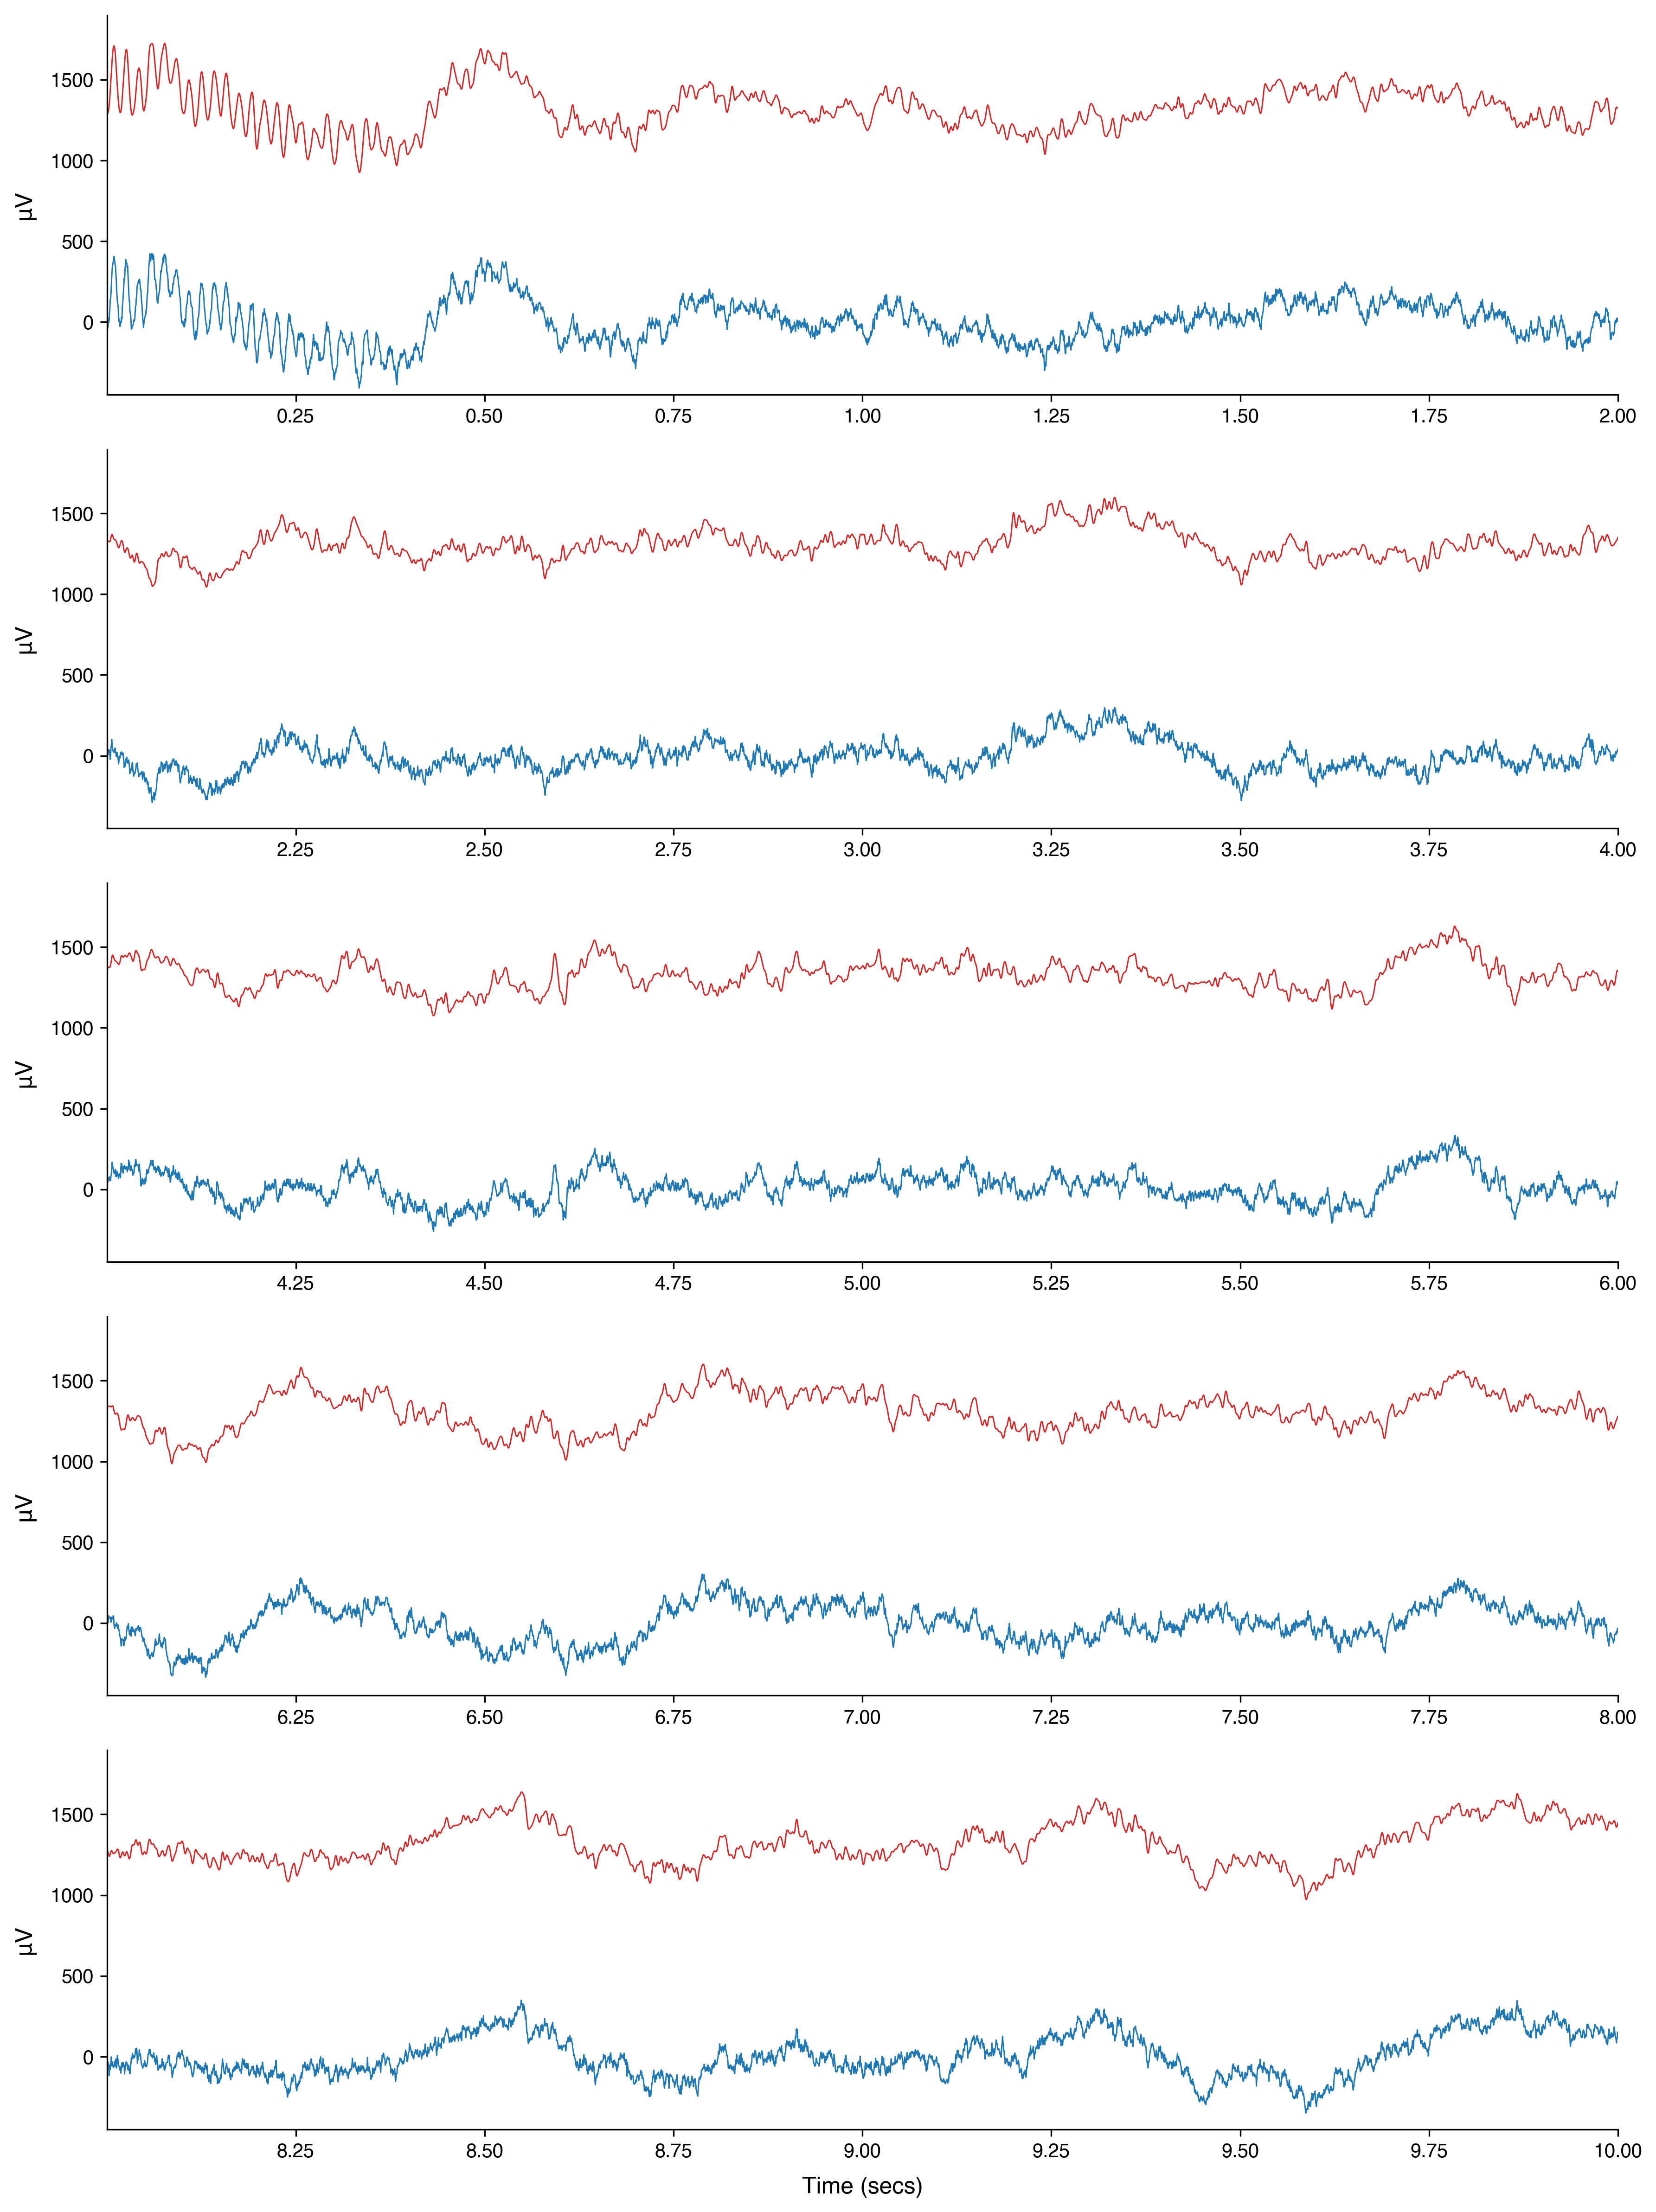

In [47]:
plt.close()
fig, ax = plot_trace2(np.vstack((_lfp, lfp_filt)), duration=10, nwin=5)
fig.show()

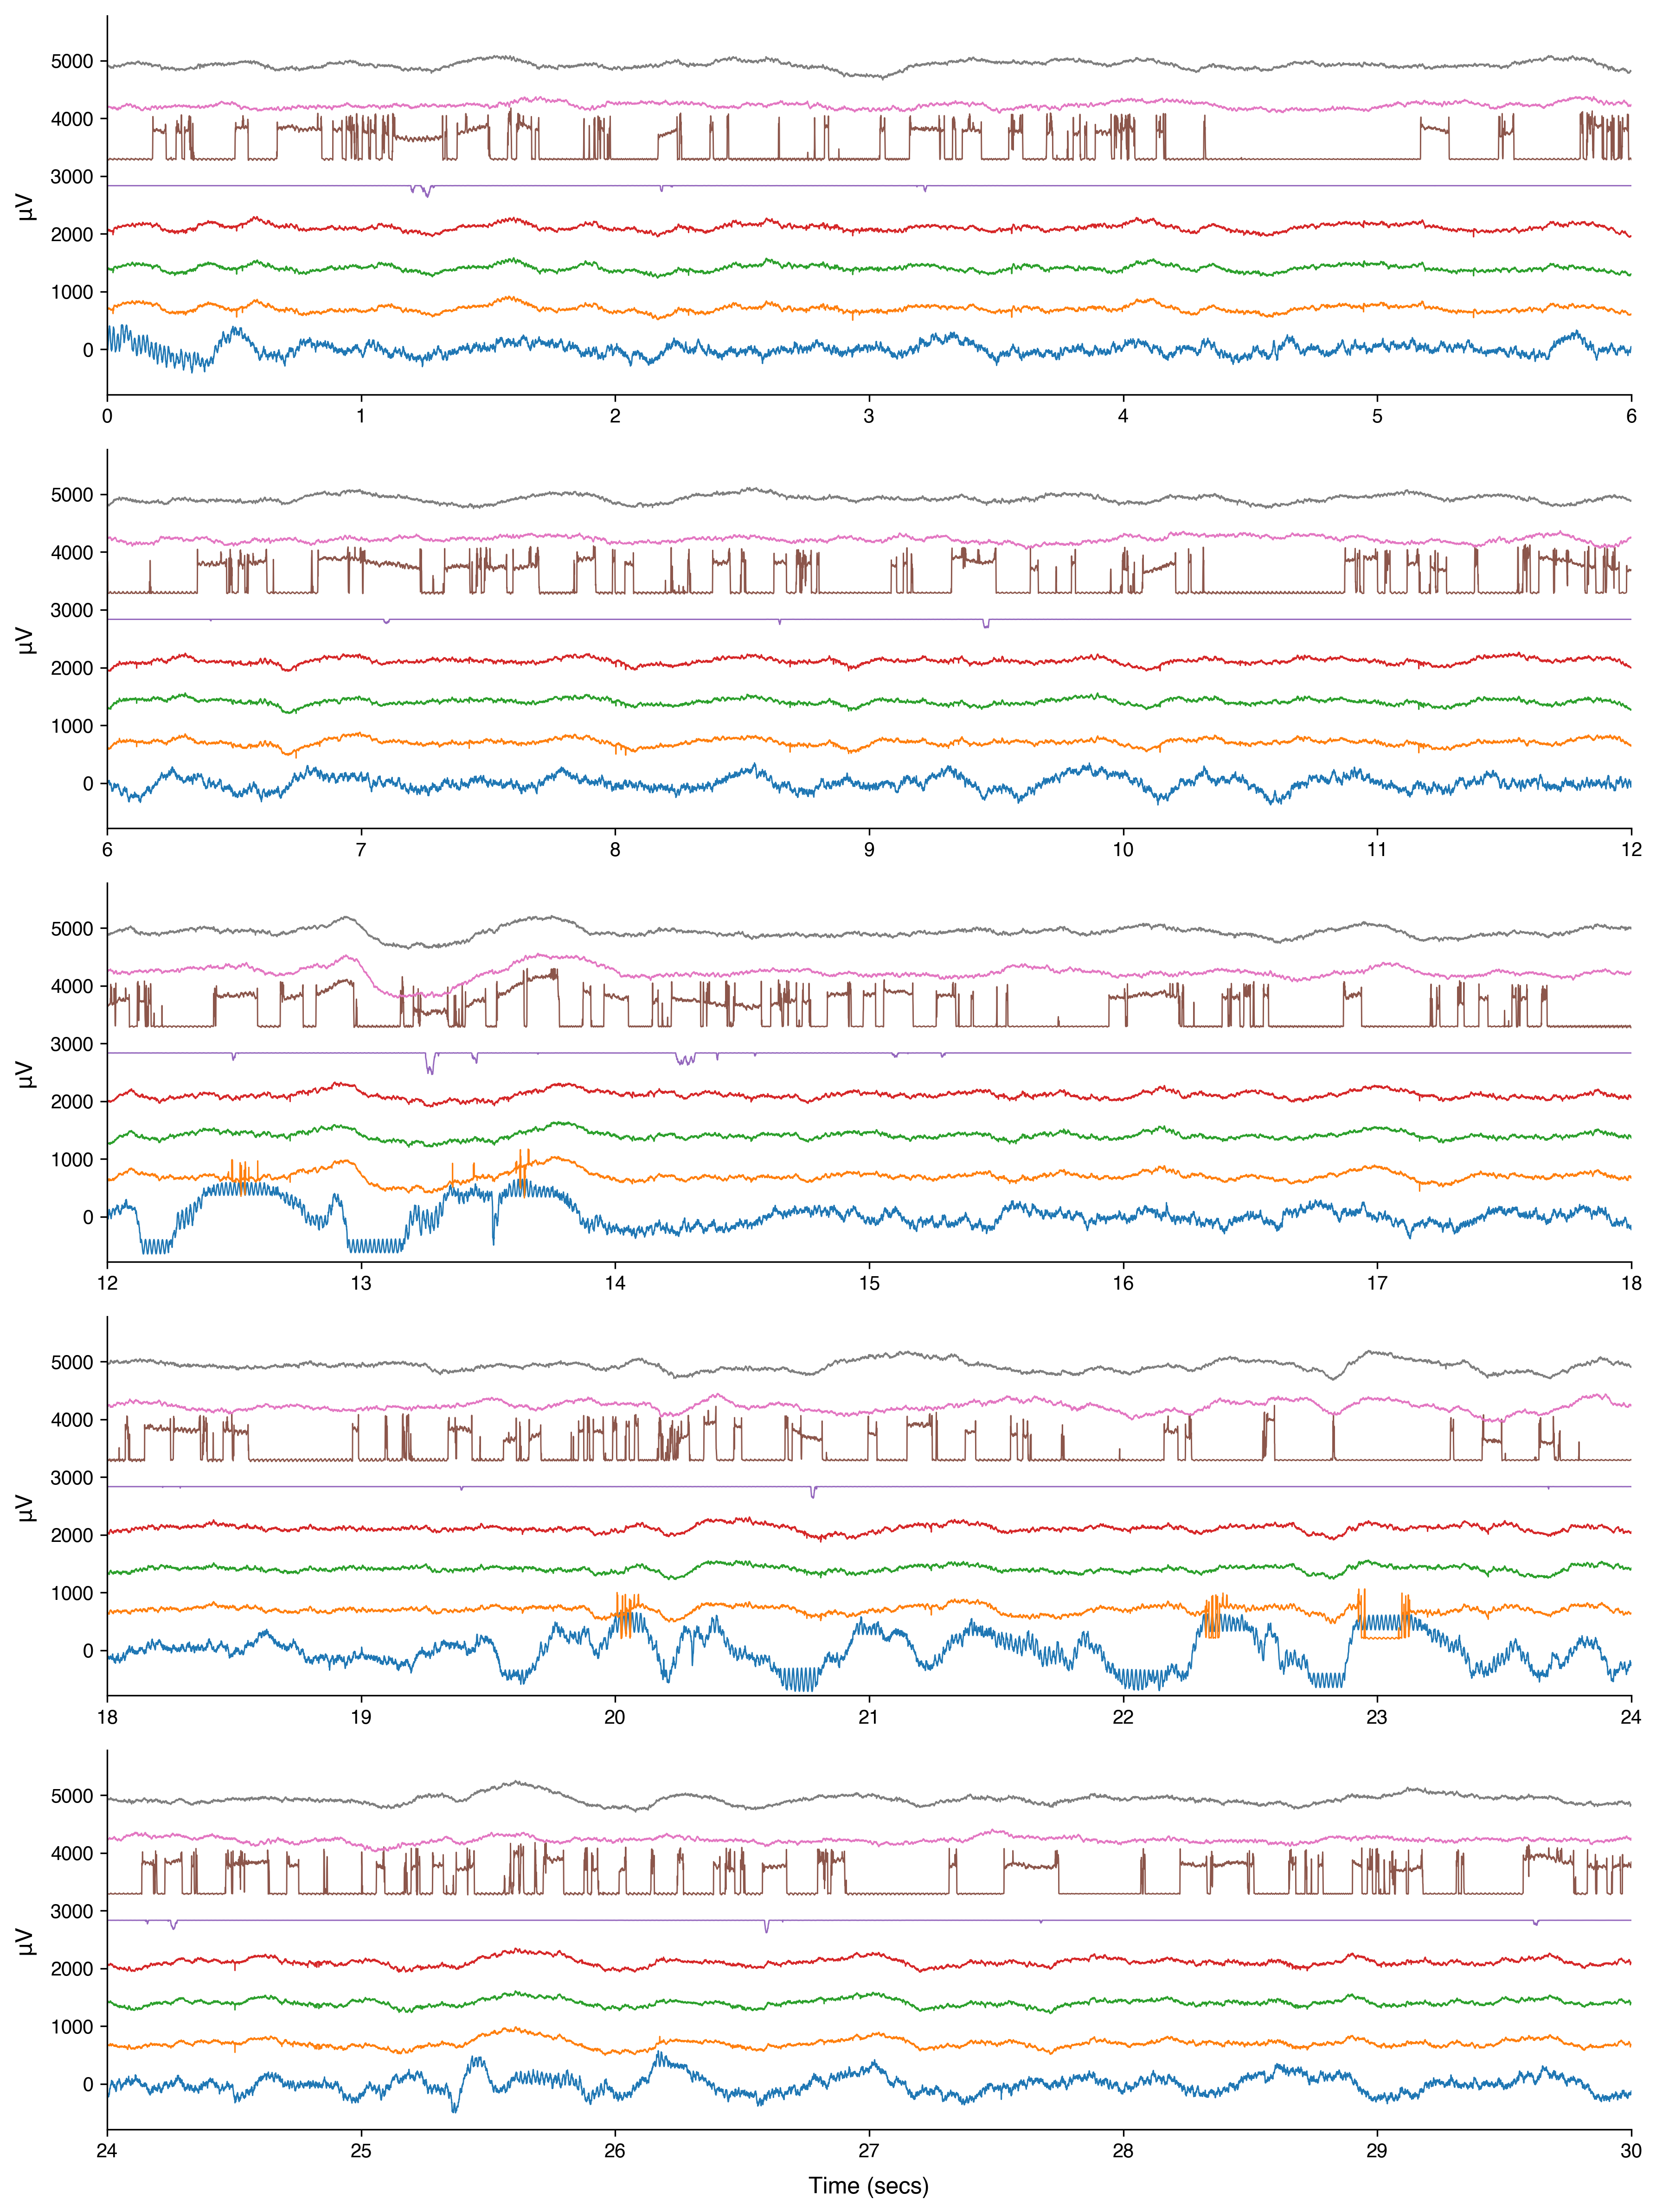

In [32]:
dur = 30
dat = lfp.values[:, :int(sr*dur)]

colors = sns.color_palette('tab10')[:dat.shape[0]]
plt.close()
fig, ax = plot_trace2(lfp, start=0, duration=dur, nwin=5, colors=colors)
fig.show()

In [ ]:
calc_phase_locking_mrl_morlet_unit_to_region2()

In [286]:
np.mean(hfa_mask>0, axis=1), np.mean(hfa_mask>0, axis=1) * sr

(array([0.00115069, 0.01644324, 0.02007938, 0.02420782, 0.036294  ,
        0.06401749, 0.00076893, 0.01628015]),
 array([  2.30138695,  32.88647349,  40.15876974,  48.41564433,
         72.58799398, 128.03498108,   1.5378629 ,  32.56029947]))

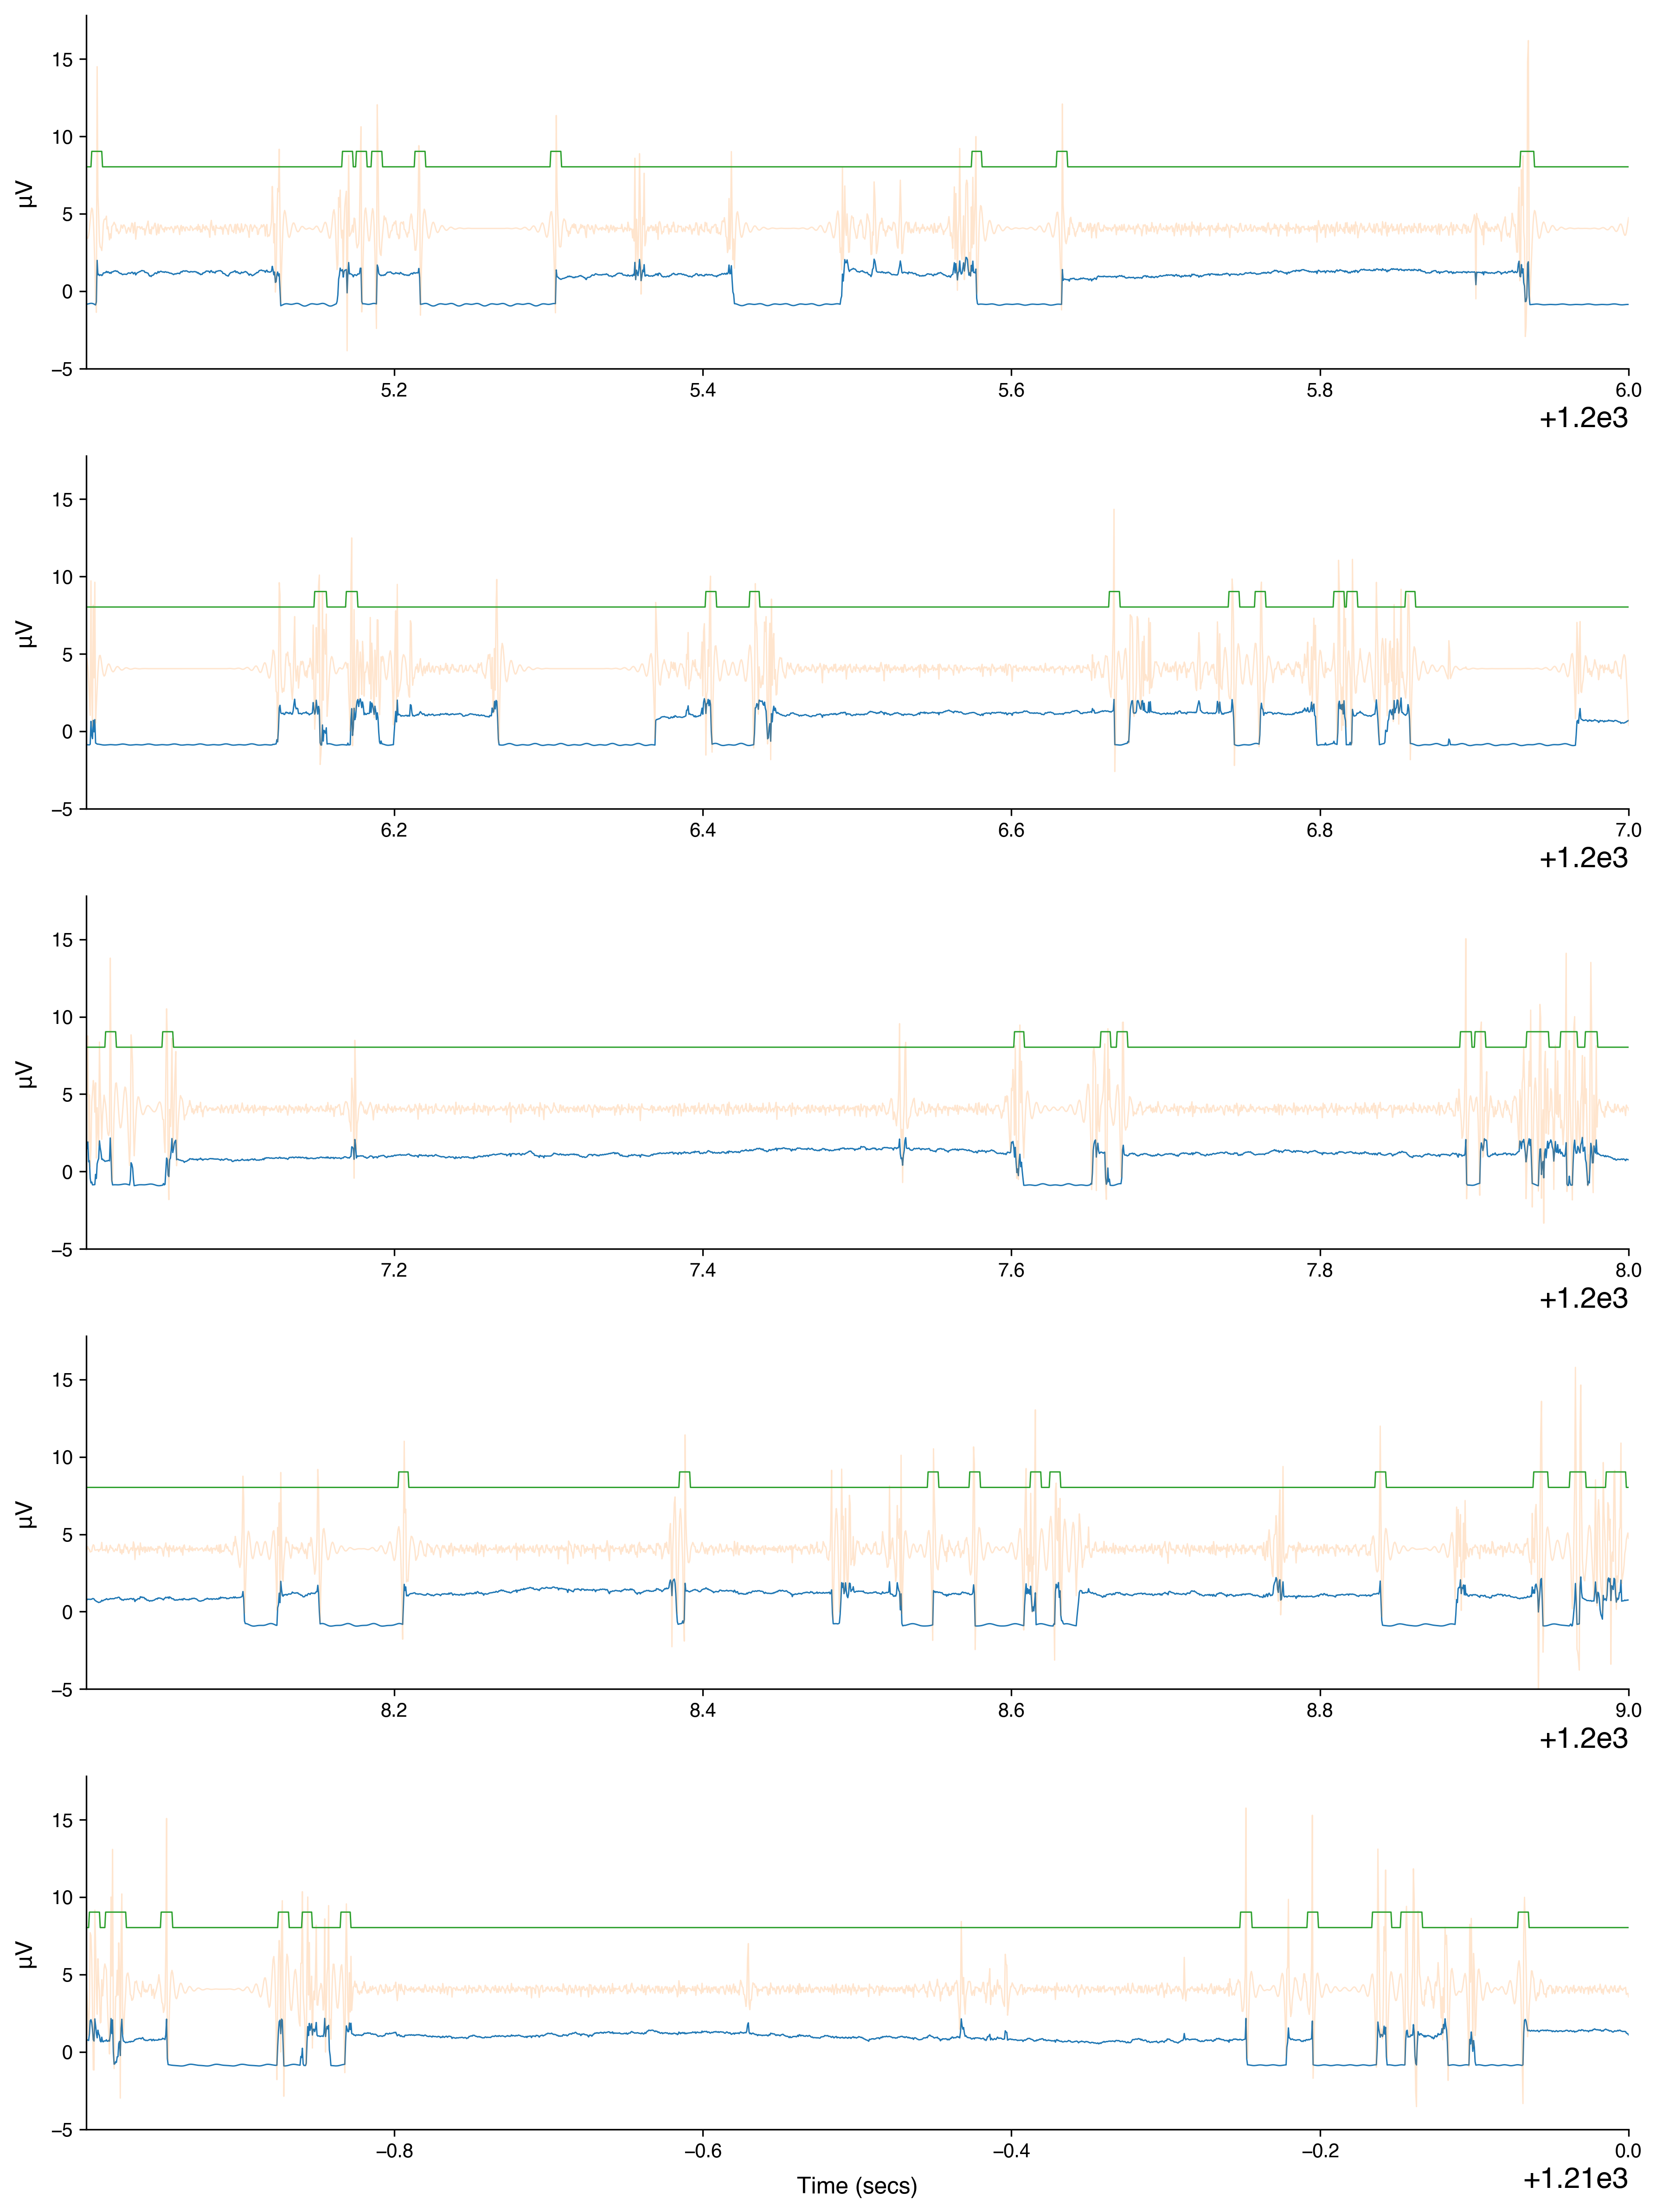

In [326]:
# n_chan = hfa_mask.shape[0]
# colors = sns.color_palette('tab10')[:n_chan] * 2
#dat = np.vstack((stats.zscore(lfp, axis=1), hfa_mask))
hfa_filename = op.join(hfa_dir, 'hfa_inds-2000Hz-zthresh5-win3ms-U371_env1-iChan45.pkl')
hfa_inds = dio.open_pickle(hfa_filename)
hfa_mask = np.zeros(lfp.shape[1], dtype=int)
hfa_mask[hfa_inds] = 1
dat = np.vstack((stats.zscore(lfp[5:6, :], axis=1),
                 stats.zscore(lfp_filt[5:6, :], axis=1),
                 np.expand_dims(hfa_mask, 0)))

plt.close()
#colors = sns.color_palette('tab10')[:int(dat.shape[0]/2)] * 3
colors = sns.color_palette('tab10')[:dat.shape[0]]
fig, ax = plot_trace2(dat/1e6, start=1205, duration=5, nwin=5, colors=colors, alphas=[1, 0.2, 1])
for iax in range(len(ax)):
    ax[iax].set_ylim(-5, ax[iax].get_ylim()[1])
fig.show()